In [143]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer

import pickle
import numpy as np
import json
import requests

In [96]:
dataset = get_dataset("airpassengers")

In [93]:
dataset.metadata

MetaData(freq='1M', target=None, feat_static_cat=[], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=12)

In [76]:
deepar = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = deepar.train(dataset.train)

100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.55it/s, epoch=5/5, avg_epoch_loss=3.86]


In [77]:
with open('gluonts_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [78]:
# with open('gluonts_model', 'rb') as f:
#     model = pickle.load(f)

<AxesSubplot:>

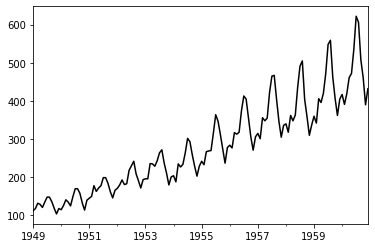

In [79]:
# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

In [80]:
true_values[:-36]

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1957-08    467.0
1957-09    404.0
1957-10    347.0
1957-11    305.0
1957-12    336.0
Freq: M, Length: 108, dtype: float32

In [81]:
prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

https://ts.gluon.ai/stable/tutorials/forecasting/quick_start_tutorial.html

In [63]:
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [52]:
# define the parameters of the dataset
custom_ds_metadata = {
    "num_series": 100,
    "num_steps": 24 * 7,
    "prediction_length": 24,
    "freq": "1H",
    "start": [pd.Period("01-01-2019", freq="1H") for _ in range(100)],
}

In [54]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(
        np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period))
    )
    sin_Zero_2Pi = np.sin(
        np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period))
    )

    pattern = np.concatenate(
        (
            np.tile(sin_minusPi_Pi.reshape(1, -1), (int(np.ceil(num_series / 2)), 1)),
            np.tile(sin_Zero_2Pi.reshape(1, -1), (int(np.floor(num_series / 2)), 1)),
        ),
        axis=0,
    )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (np.zeros((num_series, period)), target[:, :-period]), axis=1
    )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate(
        (
            np.zeros(int(np.ceil(num_series / 2))),
            np.ones(int(np.floor(num_series / 2))),
        ),
        axis=0,
    )

    return target, feat_dynamic_real, feat_static_cat

In [55]:
data_out = create_dataset(
    custom_ds_metadata["num_series"],
    custom_ds_metadata["num_steps"],
    custom_ds_metadata["prediction_length"],
)

target, feat_dynamic_real, feat_static_cat = data_out

In [64]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target[:, : -custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]],
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [93]:
test_ds_list = [
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: [fdr],
        FieldName.FEAT_STATIC_CAT: [fsc],
    }
    for (target, start, fdr, fsc) in zip(
        target, custom_ds_metadata["start"], feat_dynamic_real, feat_static_cat
    )
]

In [137]:
test_ds_json_dict = {}
for i, entry in enumerate(test_ds):
    entry_dict = {}
    entry_dict['start'] = str(entry['start'])
    entry_dict['target'] = json.dumps(pickle.dumps(entry['target']).decode('latin-1'))
    entry_dict['feat_dynamic_real'] = json.dumps(pickle.dumps(entry['feat_dynamic_real']).decode('latin-1'))
    entry_dict['feat_static_cat'] = json.dumps(pickle.dumps(entry['feat_static_cat']).decode('latin-1'))
    test_ds_json_dict[i] = json.dumps(entry_dict)

In [138]:
input_json = json.dumps(test_ds_json_dict)

In [65]:
deepar = DeepAREstimator(
    prediction_length=custom_ds_metadata["prediction_length"],
    freq=custom_ds_metadata["freq"],
    trainer=Trainer(epochs=5)
)
model = deepar.train(dataset.train)

100%|███████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.23it/s, epoch=5/5, avg_epoch_loss=3.92]


In [ ]:
with open('gluonts_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [159]:
url = 'http://localhost:9000/api/v0.1/predictions'

In [ ]:
data = {}
data['jsonData'] = input_json

In [ ]:
test_ds_json_dict = json.loads(input_json)

entry_json = json.loads(test_ds_json_dict[str(0)])

In [175]:
response = requests.post(url, json=data, timeout=None)

In [176]:
response.status_code

200

In [177]:
js = response.json()
data = js.get("data")
tensor = data.get("tensor")
shape = tensor.get("shape")
values = tensor.get("values")
prediction_samples = np.array(values).reshape(shape)

In [178]:
prediction_samples

array([[[ 1.74968541,  1.76095605, -0.11252186, ...,  1.41251779,
          1.7270298 ,  1.08520484],
        [ 1.30309284,  1.87289548,  0.87729073, ...,  1.83283603,
          0.93508703,  0.08338691],
        [ 1.60517395,  1.26462483,  0.69677031, ...,  1.39036775,
          1.71701038,  1.39198792],
        ...,
        [ 0.97467518,  0.93414474,  0.8418805 , ...,  1.214571  ,
          1.10813749,  1.6725992 ],
        [ 1.22128844,  0.83461022,  1.13273168, ...,  0.92765862,
          1.35331213,  1.05986965],
        [ 0.86357456,  0.17654993, -0.01487936, ...,  1.41134584,
          1.27037239,  1.05056453]],

       [[ 0.33679685,  1.26923335,  0.78098214, ...,  0.27934897,
          0.99528211,  0.88594866],
        [ 1.21838689,  0.73931181,  0.30097649, ...,  0.97751683,
          1.23383963,  1.3474623 ],
        [ 1.36849391,  1.39483178,  0.94455975, ...,  1.90182304,
          0.79079801,  1.2601763 ],
        ...,
        [ 0.89048731,  0.5185498 ,  1.41366303, ...,  

In [179]:
prediction_samples.shape

(100, 100, 24)